In [18]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd

In [19]:
path_list = glob.glob("../all_results/non_linear/contrastive_*")
path_list

['../all_results/non_linear/contrastive_run_0.pkl',
 '../all_results/non_linear/contrastive_run_1.pkl',
 '../all_results/non_linear/contrastive_run_2.pkl',
 '../all_results/non_linear/contrastive_run_4.pkl',
 '../all_results/non_linear/contrastive_run_3.pkl']

In [20]:
eg_data = pd.read_pickle(path_list[0])

In [21]:
all_results = [pd.read_pickle(path) for path in path_list]

In [22]:
all_model_keys = list(eg_data.keys())
print(eg_data.keys())
print(eg_data["contrastive_hebb"].keys())
[print(key, type(val)) for key, val in eg_data["contrastive_hebb"].items()]
print("weight shape", eg_data["contrastive_hebb"]["learned_W1"].shape)
print("angles shape", eg_data["contrastive_hebb"]["data"].angles.shape)
np.equal(eg_data["gradient_descent"]["learned_W1"][0, ...], eg_data["gradient_descent"]["learned_W1"][-1, ...]).all()

dict_keys(['gradient_descent', 'contrastive', 'quasi_predictive', 'hebbian', 'anti_hebbian', 'contrastive_hebb', 'contrastive_anti_hebb', 'quasi_predictive_hebb', 'quasi_predictive_anti_hebb'])
dict_keys(['loss', 'learned_W1', 'learned_W2', 'W1_grad', 'W2_grad', 'save_every', 'data', 'learning_rate', 'tuned_neurons_width'])
loss <class 'numpy.ndarray'>
learned_W1 <class 'numpy.ndarray'>
learned_W2 <class 'numpy.ndarray'>
W1_grad <class 'numpy.ndarray'>
W2_grad <class 'numpy.ndarray'>
save_every <class 'int'>
data <class 'vpl_model.tasks.angle_discrimination_task.AngleDiscriminationTask'>
learning_rate <class 'float'>
tuned_neurons_width <class 'int'>
weight shape (100, 40, 80)
angles shape (80,)


False

In [23]:
def compute_mean_func(path_list, model_key, func, func_kwargs):
    all_quant = []
    for path in path_list:
        results = pd.read_pickle(path)[model_key]
        all_quant.append(func(results, **func_kwargs))
    all_quant = np.stack(all_quant, axis=0)
    return np.mean(all_quant, axis=0), np.std(all_quant, axis=0)

In [24]:
def get_amplitude(results, weight_index=-1):
    W1 = np.array(results["learned_W1"][weight_index, ...])
    amp = np.mean(W1, axis=0)
    return np.linspace(0, 180, num=len(amp)), amp

In [25]:
def get_amplitude_PO_TO(results, weight_index=-1, TO=90):
    W1 = np.array(results["learned_W1"][weight_index, ...])
    data = results["data"]
    
    PO_index = np.argmax(W1, axis=1)
    angles = data.angles
    
    PO = angles[PO_index]
    #slopes = np.diff(np.concatenate([W1, W1[:, 1][:, np.newaxis]], axis=1), axis=1)
    x_axis = PO - TO
    TO_index = np.argmin(np.abs(angles-TO))
    y_axis = np.amax(W1, axis=1) - np.amin(W1, axis=1)
    
    sort_index = np.argsort(x_axis)
    x_axis = x_axis[sort_index]
    y_axis = y_axis[sort_index]
    return x_axis, y_axis

In [26]:
def loss_func(results):
    return np.array(results["loss"])

def plt_errorbar(x, mean, std, ax, lw=3, color="C0", alpha=0.4, label="", linestyle="-"):
    #ax.fill_between(x, y1=mean+2*std, y2=mean-2*std, color="C0", alpha=alpha)
    ax.plot(x, mean, lw=lw, color=color, label=label, linestyle=linestyle)
    return ax

In [27]:
def slope_PO_TO(results, normalize_tuning=True, weight_index=-1, TO=90.0):
    W1 = np.array(results["learned_W1"][weight_index, ...])
    data = results["data"]
    
    PO_index = np.argmax(W1, axis=1)
    angles = data.angles
    if normalize_tuning:
        W1 = W1/np.amax(W1, axis=1)[:, np.newaxis]
    
    PO = angles[PO_index]
    slopes = np.diff(np.concatenate([W1, W1[:, 1][:, np.newaxis]], axis=1), axis=1)
    x_axis = PO - TO
    TO_index = np.argmin(np.abs(angles-TO))
    y_axis = slopes[:, TO_index]
    
    sort_index = np.argsort(x_axis)
    x_axis = x_axis[sort_index]
    y_axis = y_axis[sort_index]
    return x_axis, y_axis

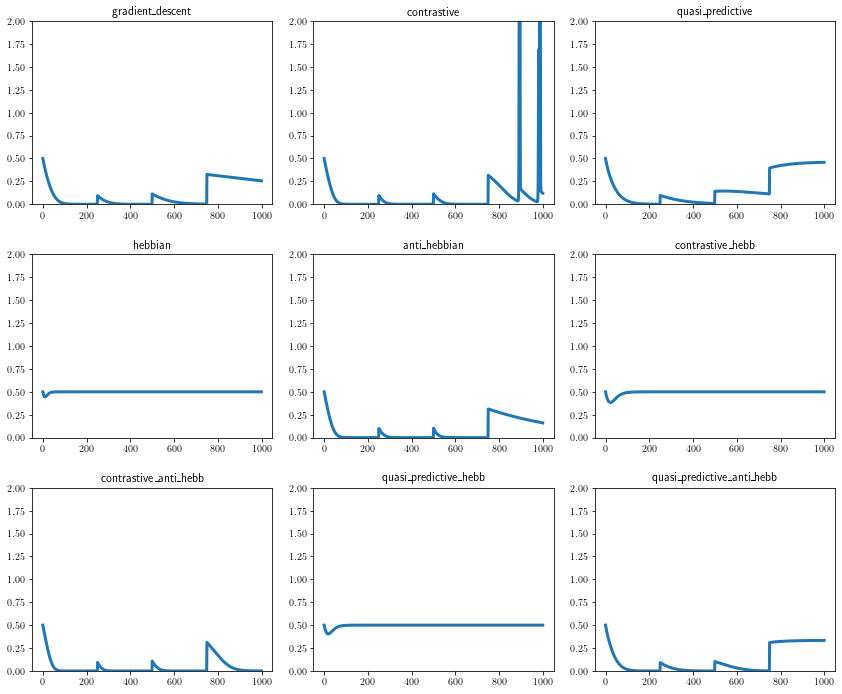

In [28]:
f, ax = plt.subplots(3, 3, figsize=(12, 10))
ax = ax.flatten()
for i, model_key in enumerate(all_model_keys):
    mean_loss, std_loss = compute_mean_func(path_list, model_key, loss_func, func_kwargs={})
    ax[i] = plt_errorbar(list(np.arange(len(mean_loss))), mean_loss, std_loss, ax=ax[i])
    ax[i].set_title(model_key)
    ax[i].set_ylim([0, 2])
f.tight_layout(pad=2.0)

gradient_descent
(40,) (40,) (40,)
contrastive
(40,) (40,) (40,)
quasi_predictive
(40,) (40,) (40,)
hebbian
(40,) (40,) (40,)
anti_hebbian
(40,) (40,) (40,)
contrastive_hebb
(40,) (40,) (40,)
contrastive_anti_hebb
(40,) (40,) (40,)
quasi_predictive_hebb
(40,) (40,) (40,)
quasi_predictive_anti_hebb
(40,) (40,) (40,)


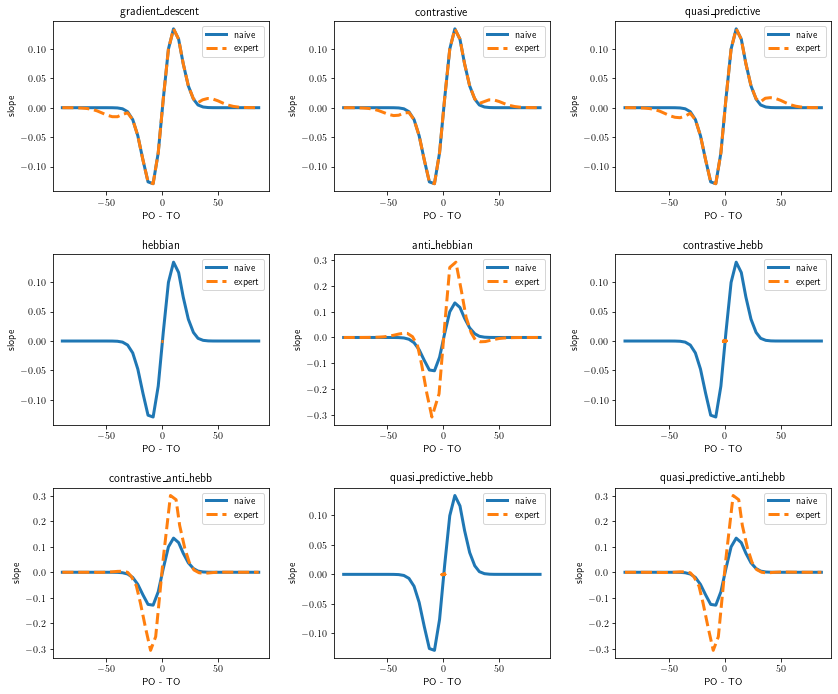

In [29]:
f, ax = plt.subplots(3, 3, figsize=(12, 10))
ax = ax.flatten()
for i, model_key in enumerate(all_model_keys):
    mean_x_y, std_x_y = compute_mean_func(path_list, model_key, slope_PO_TO, func_kwargs={"weight_index": 0})
    x, y, y_err = mean_x_y[0], mean_x_y[1], std_x_y[1]
    ax[i] = plt_errorbar(x, y, y_err, ax=ax[i], color="C0", label="naive")
    
    print(model_key)
    mean_x_y, std_x_y = compute_mean_func(path_list, model_key, slope_PO_TO, func_kwargs={"weight_index": -1})
    x, y, y_err = mean_x_y[0], mean_x_y[1], std_x_y[1]
    print(x.shape, y.shape, y_err.shape)
    ax[i] = plt_errorbar(x, y, y_err, ax=ax[i], color="C1", label="expert", linestyle="--")

    
    ax[i].legend()
    ax[i].set_title(model_key)
    ax[i].set_xlabel("PO - TO")
    ax[i].set_ylabel("slope")
f.tight_layout(pad=2.0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


gradient_descent
contrastive
quasi_predictive


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


hebbian
anti_hebbian


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


contrastive_hebb
contrastive_anti_hebb
quasi_predictive_hebb
quasi_predictive_anti_hebb


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


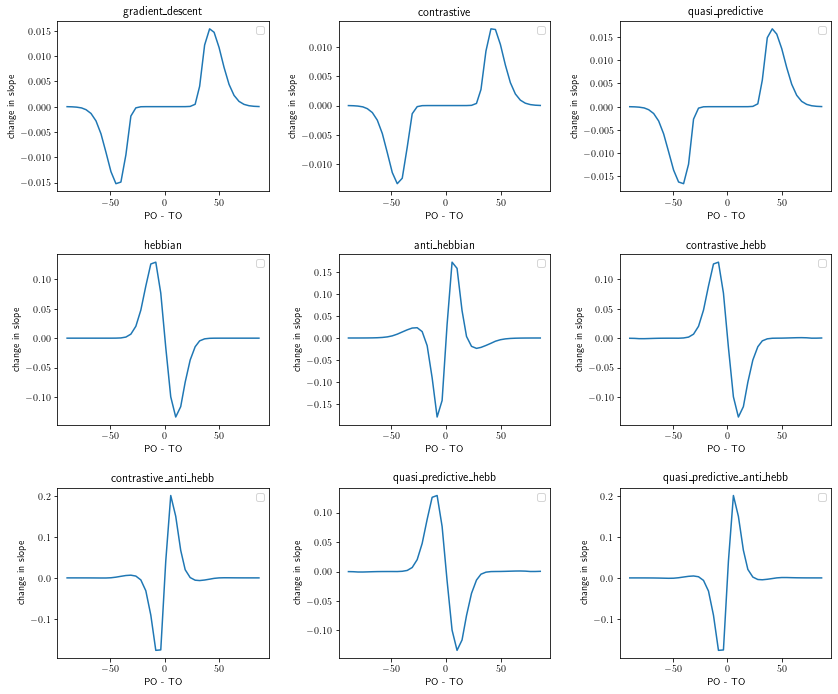

In [30]:
f, ax = plt.subplots(3, 3, figsize=(12, 10))
ax = ax.flatten()
for i, model_key in enumerate(all_model_keys):
    exp_mean_x_y, exp_std_x_y = compute_mean_func(path_list, model_key, slope_PO_TO, func_kwargs={"weight_index": -1})
    exp_x, exp_y, exp_y_err = exp_mean_x_y[0], exp_mean_x_y[1], exp_std_x_y[1]
    #ax[i] = plt_errorbar(x, y, y_err, ax=ax[i], color="C0", label="naive")
    
    print(model_key)
    mean_x_y, std_x_y = compute_mean_func(path_list, model_key, slope_PO_TO, func_kwargs={"weight_index": 0})
    x, y, y_err = mean_x_y[0], mean_x_y[1], std_x_y[1]
    # print(x, y)
    # ax[i] = plt_errorbar(x, y, y_err, ax=ax[i], color="C1", label="expert")
    ax[i].plot(x, exp_y-y)
    
    ax[i].legend()
    ax[i].set_title(model_key)
    ax[i].set_xlabel("PO - TO")
    ax[i].set_ylabel("change in slope")
f.tight_layout(pad=2.0)

In [31]:
model_training_span = {'gradient_descent': [1, 24, 49, 74, 99], 
                       'contrastive': [1, 24, 49, 74, 99], 
                       'quasi_predictive': [1, 24, 49, 74, 99], 
                       #'hebbian', 
                       #'anti_hebbian': [1, 250, 500, 750, 1000], 
                       #'contrastive_hebb', 
                       #'contrastive_anti_hebb': [1, 60, 120, 180, 240], 
                       #'quasi_predictive_hebb': , 
                       #'quasi_predictive_anti_hebb': [1, 100, 200, 300, 400],
                      }


In [32]:
model_training_span

{'gradient_descent': [1, 24, 49, 74, 99],
 'contrastive': [1, 24, 49, 74, 99],
 'quasi_predictive': [1, 24, 49, 74, 99]}

In [33]:
labels = {'gradient_descent': "Gradient Descent",
 'contrastive': "Contrastive Hebbian",
 'quasi_predictive': "Quasi predictive coding"}
 #"anti_hebbian": "Anti-Hebbian",
 #"contrastive_anti_hebb": "Contr Anti-Hebbian",
 #     "quasi_predictive_anti_hebb": "Predictive Anti-Hebbian"   }

/tmp/ipykernel_24564/209680552.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', 6)


gradient_descent
contrastive
quasi_predictive


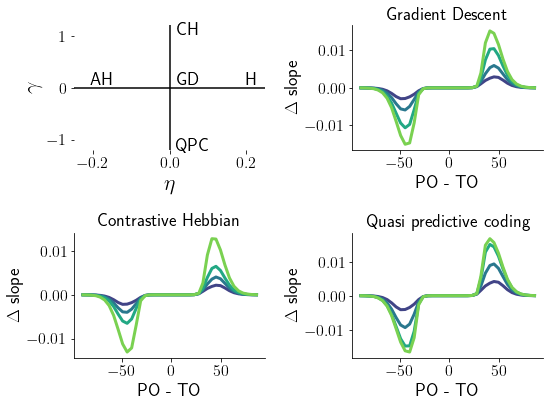

In [34]:
fontsize = 18
linewidth = 3
plt.rcParams['text.usetex'] = True
f, ax = plt.subplots(2, 2, figsize=(8, 6))
ax = ax.flatten()
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 6)
for i, model_key in enumerate(model_training_span.keys()):
    
    print(model_key)
    mean_x_y, std_x_y = compute_mean_func(path_list, model_key, slope_PO_TO, func_kwargs={"weight_index": 0})
    x, y, y_err = mean_x_y[0], mean_x_y[1], std_x_y[1]
    for j, index in enumerate(model_training_span[model_key]):
        mean_x_y, std_x_y = compute_mean_func(path_list, model_key, slope_PO_TO, func_kwargs={"weight_index": int(index)-1})
        y_i = mean_x_y[1]
        if j == 0:
            continue
        if i == 1:
            ax[i+1].plot(x, y_i-y, color=viridis(j), label="training stage "+str(j), lw=linewidth)
        else:
            ax[i+1].plot(x, y_i-y, color=viridis(j), lw=linewidth)
    #ax[i+1].legend(bbox_to_anchor=(1.1, 1.05), frameon=False)
    
    ax[i+1].set_title(labels[model_key], fontsize=fontsize)
    ax[i+1].set_xlabel("PO - TO", fontsize=fontsize)
    ax[i+1].set_ylabel("$\Delta$ slope", fontsize=fontsize)
    ax[i+1].spines[['right', 'top']].set_visible(False)
    ax[i+1].tick_params(axis='both', which='major', labelsize=fontsize-2)

plot_index = 0
#x = np.arange(len(total_loss))
#ax[plot_index].plot(cumulated_loss, "k", alpha=1, lw=lw)#, lw=lw, label="Batch training")
ax[plot_index].spines[['right', 'top', "bottom", "left"]].set_visible(False)
#ax[plot_index].legend(fontsize=fontsize, frameon=False)
#ax[plot_index].spines[['right', 'top']].set_visible(False)
ax[plot_index].set_xlabel("$\eta$", fontsize=fontsize+4)
ax[plot_index].set_ylabel("$\gamma$", fontsize=fontsize+4)
ax[plot_index].tick_params(axis='both', which='major', labelsize=fontsize-2)
ax[plot_index].axvline(0, color="k")
ax[plot_index].axhline(0, color="k")
ax[plot_index].set_xlim([-0.25, 0.25])
ax[plot_index].set_ylim([-1.2, 1.2])
#ax[plot_index].scatter(0, 0, s=250, color="k", zorder=2)
#ax[plot_index].scatter(0.2, 1.0, s=250, zorder=2)
ax[plot_index].text(0.02, 0.05, "GD", #transform=ax[plot_index].transAxes,
                  size=fontsize, weight='bold')
ax[plot_index].text(0.02, 1.0, "CH", #transform=ax[plot_index].transAxes,
                  size=fontsize, weight='bold')
ax[plot_index].text(0.015, -1.2, "QPC", #transform=ax[plot_index].transAxes,
                  size=fontsize, weight='bold')
ax[plot_index].text(0.2, 0.05, "H", #transform=ax[plot_index].transAxes,
                  size=fontsize, weight='bold')
ax[plot_index].text(-0.21, 0.05, "AH", #transform=ax[plot_index].transAxes,
                  size=fontsize, weight='bold')
#ax[plot_index].text(0.16, 0.7, "Control", color="C0", #transform=ax[plot_index].transAxes,
#                  size=fontsize, weight='bold')


f.tight_layout(pad=2.0)
plt.savefig("long_curriculum.pdf")

/tmp/ipykernel_18354/2059248524.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', 5)


gradient_descent
contrastive
quasi_predictive


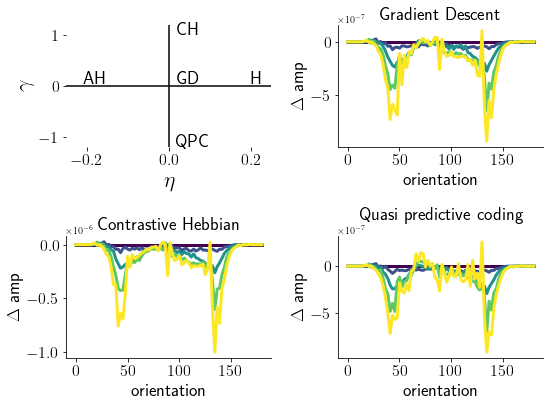

In [33]:
fontsize = 18
linewidth = 3
plt.rcParams['text.usetex'] = True
f, ax = plt.subplots(2, 2, figsize=(8, 6))
ax = ax.flatten()
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 5)
for i, model_key in enumerate(model_training_span.keys()):
    
    print(model_key)
    mean_x_y, std_x_y = compute_mean_func(path_list, model_key, get_amplitude, func_kwargs={"weight_index": 0})
    x, y, y_err = mean_x_y[0], mean_x_y[1], std_x_y[1]
    for j, index in enumerate(model_training_span[model_key]):
        mean_x_y, std_x_y = compute_mean_func(path_list, model_key, get_amplitude, func_kwargs={"weight_index": index-1})
        y_i = mean_x_y[1]
        if i == 0:
            ax[i+1].plot(x, y_i-y, color=viridis(j), label="training stage", lw=linewidth)
            #ax[i].legend()
        else:
            ax[i+1].plot(x, y_i-y, color=viridis(j), lw=linewidth)
    
    ax[i+1].set_title(labels[model_key], fontsize=fontsize)
    ax[i+1].set_xlabel("orientation", fontsize=fontsize)
    ax[i+1].set_ylabel("$\Delta$ amp", fontsize=fontsize)
    ax[i+1].spines[['right', 'top']].set_visible(False)
    ax[i+1].tick_params(axis='both', which='major', labelsize=fontsize-2)

plot_index = 0
#x = np.arange(len(total_loss))
#ax[plot_index].plot(cumulated_loss, "k", alpha=1, lw=lw)#, lw=lw, label="Batch training")
ax[plot_index].spines[['right', 'top', "bottom", "left"]].set_visible(False)
#ax[plot_index].legend(fontsize=fontsize, frameon=False)
#ax[plot_index].spines[['right', 'top']].set_visible(False)
ax[plot_index].set_xlabel("$\eta$", fontsize=fontsize+4)
ax[plot_index].set_ylabel("$\gamma$", fontsize=fontsize+4)
ax[plot_index].tick_params(axis='both', which='major', labelsize=fontsize-2)
ax[plot_index].axvline(0, color="k")
ax[plot_index].axhline(0, color="k")
ax[plot_index].set_xlim([-0.25, 0.25])
ax[plot_index].set_ylim([-1.2, 1.2])
#ax[plot_index].scatter(0, 0, s=250, color="k", zorder=2)
#ax[plot_index].scatter(0.2, 1.0, s=250, zorder=2)
ax[plot_index].text(0.02, 0.05, "GD", #transform=ax[plot_index].transAxes,
                  size=fontsize, weight='bold')
ax[plot_index].text(0.02, 1.0, "CH", #transform=ax[plot_index].transAxes,
                  size=fontsize, weight='bold')
ax[plot_index].text(0.015, -1.2, "QPC", #transform=ax[plot_index].transAxes,
                  size=fontsize, weight='bold')
ax[plot_index].text(0.2, 0.05, "H", #transform=ax[plot_index].transAxes,
                  size=fontsize, weight='bold')
ax[plot_index].text(-0.21, 0.05, "AH", #transform=ax[plot_index].transAxes,
                  size=fontsize, weight='bold')
#ax[plot_index].text(0.16, 0.7, "Control", color="C0", #transform=ax[plot_index].transAxes,
#                  size=fontsize, weight='bold')


f.tight_layout(pad=2.0)
plt.savefig("amplitude_long_curriculum.pdf")

/tmp/ipykernel_18354/1105653450.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', 6)


gradient_descent
contrastive
quasi_predictive


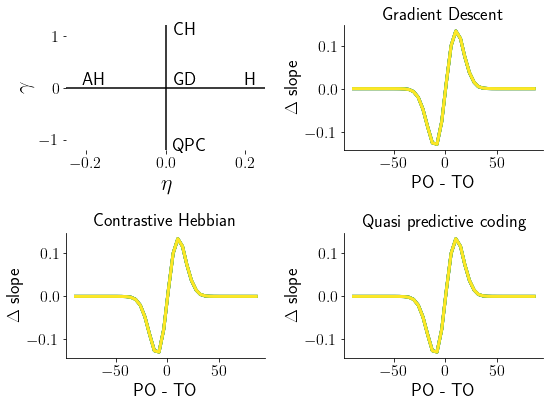

In [34]:
fontsize = 18
linewidth = 3
plt.rcParams['text.usetex'] = True
f, ax = plt.subplots(2, 2, figsize=(8, 6))
ax = ax.flatten()
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 6)
for i, model_key in enumerate(model_training_span.keys()):
    
    print(model_key)
    mean_x_y, std_x_y = compute_mean_func(path_list, model_key, slope_PO_TO, func_kwargs={"weight_index": 0})
    x, y, y_err = mean_x_y[0], mean_x_y[1], std_x_y[1]
    ax[i+1].plot(x, y, color=viridis(j), label="training stage", lw=linewidth)
    for j, index in enumerate(model_training_span[model_key]):
        mean_x_y, std_x_y = compute_mean_func(path_list, model_key, slope_PO_TO, func_kwargs={"weight_index": index-1})
        y_i = mean_x_y[1]
        if i == 0:
            ax[i+1].plot(x, y_i, color=viridis(j+1), label="training stage", lw=linewidth)
            #ax[i].legend()
        else:
            ax[i+1].plot(x, y_i, color=viridis(j+1), lw=linewidth)
    
    ax[i+1].set_title(labels[model_key], fontsize=fontsize)
    ax[i+1].set_xlabel("PO - TO", fontsize=fontsize)
    ax[i+1].set_ylabel("$\Delta$ slope", fontsize=fontsize)
    ax[i+1].spines[['right', 'top']].set_visible(False)
    ax[i+1].tick_params(axis='both', which='major', labelsize=fontsize-2)

plot_index = 0
#x = np.arange(len(total_loss))
#ax[plot_index].plot(cumulated_loss, "k", alpha=1, lw=lw)#, lw=lw, label="Batch training")
ax[plot_index].spines[['right', 'top', "bottom", "left"]].set_visible(False)
#ax[plot_index].legend(fontsize=fontsize, frameon=False)
#ax[plot_index].spines[['right', 'top']].set_visible(False)
ax[plot_index].set_xlabel("$\eta$", fontsize=fontsize+4)
ax[plot_index].set_ylabel("$\gamma$", fontsize=fontsize+4)
ax[plot_index].tick_params(axis='both', which='major', labelsize=fontsize-2)
ax[plot_index].axvline(0, color="k")
ax[plot_index].axhline(0, color="k")
ax[plot_index].set_xlim([-0.25, 0.25])
ax[plot_index].set_ylim([-1.2, 1.2])
#ax[plot_index].scatter(0, 0, s=250, color="k", zorder=2)
#ax[plot_index].scatter(0.2, 1.0, s=250, zorder=2)
ax[plot_index].text(0.02, 0.05, "GD", #transform=ax[plot_index].transAxes,
                  size=fontsize, weight='bold')
ax[plot_index].text(0.02, 1.0, "CH", #transform=ax[plot_index].transAxes,
                  size=fontsize, weight='bold')
ax[plot_index].text(0.015, -1.2, "QPC", #transform=ax[plot_index].transAxes,
                  size=fontsize, weight='bold')
ax[plot_index].text(0.2, 0.05, "H", #transform=ax[plot_index].transAxes,
                  size=fontsize, weight='bold')
ax[plot_index].text(-0.21, 0.05, "AH", #transform=ax[plot_index].transAxes,
                  size=fontsize, weight='bold')
#ax[plot_index].text(0.16, 0.7, "Control", color="C0", #transform=ax[plot_index].transAxes,
#                  size=fontsize, weight='bold')


f.tight_layout(pad=2.0)
plt.savefig("slopes.pdf")